# Leading edge plot (figure 2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# load
dat = pd.read_csv('../../final_data/fulldata_cleaned_matched_GPT_colors.csv')
red_validated = pd.read_csv('../../final_data/validated_FULL_gpt_labeled_REDS_ONLY.csv')

# how many are labeled red?
num_in_red_labels = sum(dat['binomial'].isin(red_validated['binomial']))
truereds = red_validated[red_validated['validated'] == 'yes']['binomial']
num_in_red_true = sum(dat['binomial'].isin(truereds))

# screen out non-reds based on validation
not_red_sp = red_validated[red_validated['validated'] == "no"]['binomial']
dat.loc[dat['binomial'].isin(not_red_sp), 'color'] = np.nan
dat = dat.dropna(subset=['color'])

# windows for day_of_year, longitude, and latitude
dat['day_window'] = pd.cut(dat['day_of_year'], 
                           bins=[0, 40, 80, 120, 160, 200, 240, 280, 320, 366],
                           labels=["0-40", "40-80", "80-120", "120-160", "160-200",
                                   "200-240", "240-280", "280-320", "320-365"],
                           include_lowest=True)

dat['lon_window'] = pd.cut(dat['longitude'],
                           bins=[-130, -96, -59],
                           labels=["-130 to -96", "-96 to -59"],
                           include_lowest=True)

dat['lat_window'] = pd.cut(dat['latitude'],
                           bins=[24, 29, 34, 39, 44, 49, 54],
                           labels=["24-29", "29-34", "34-39", "39-44", "44-49", "49-54"],
                           include_lowest=True)

/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_76290/2923709949.py:2: DtypeWarning: Columns (14,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('../../final_data/fulldata_cleaned_matched_GPT_colors.csv')
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_76290/2923709949.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['day_window'] = pd.cut(dat['day_of_year'],
/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_76290/2923709949.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

## calculate leading edge values

In [3]:
percentile_threshold = 0.8
window_size = 15
max_day = 200  # limited to first part of year

def calculate_percentiles(dat, color, lon_range, window_size, percentile_threshold, max_day):
    subdf = dat[dat['color'] == color]
    subdf = subdf[subdf['lon_window'] == lon_range]
    percentiles = []
    
    for day in range(1, max_day - window_size + 1):
        day_range = np.arange(day, day + window_size)
        window_df = subdf[subdf['day_of_year'].isin(day_range)]
        if len(window_df) > 0:
            percentile_75 = np.percentile(window_df['latitude'], percentile_threshold * 100)
            percentiles.append(percentile_75)
        else:
            percentiles.append(np.nan)
    return percentiles

colors = ['red', 'white', 'blue', 'maroon', 'yellow', 'brown', 'purple', 'pink', 'orange', 'green']
percentiles_dict = {}

# do the calculation. note we are in eastern US bin here
for color in colors:
    percentiles_dict[color] = calculate_percentiles(dat, color, "-96 to -59", window_size, percentile_threshold, max_day)

## plotting

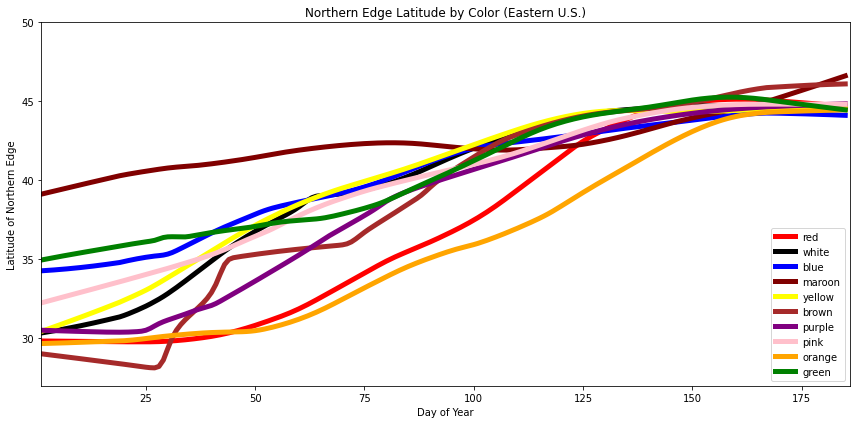

In [4]:
plt.figure(figsize=(12, 6))
x = np.arange(1, max_day - window_size + 1)
colors_map = {'red': 'red', 'white': 'black', 'blue': 'blue', 'yellow': 'yellow', 
              'brown': 'brown', 'maroon': 'maroon', 'purple': 'purple', 'pink': 'pink',
              'orange': 'orange', 'green': 'green'}

# plot the individual color lines
for color in percentiles_dict:
    y = np.array(percentiles_dict[color])
    lowess_smoothed = lowess(y, x, frac=0.2) # barely smooth to look nice
    plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], label=color, color=colors_map[color], linewidth=5)

plt.title("Northern Edge Latitude by Color (Eastern U.S.)")
plt.xlabel("Day of Year")
plt.ylabel("Latitude of Northern Edge")
plt.legend()
plt.ylim([27, 50])
plt.xlim([1, max_day - window_size + 1])
plt.tight_layout()
plt.show()

# Now lump all colors leave red, orange, and white separate:

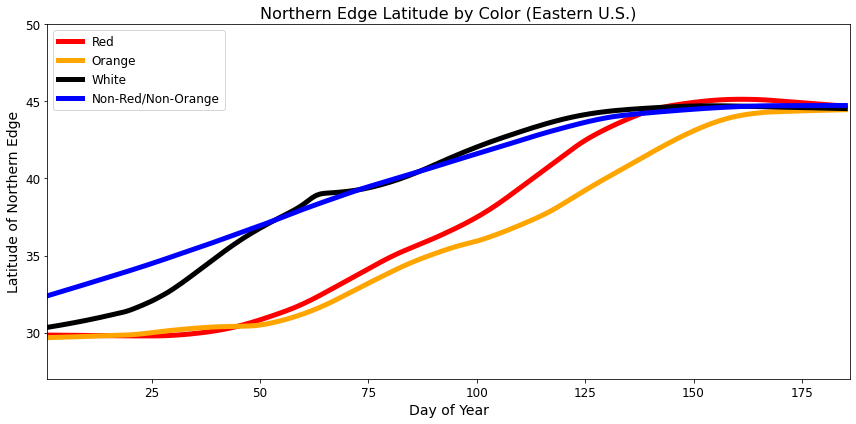

In [5]:
percentile_threshold = 0.8
window_size = 15
max_day = 200

def calculate_percentiles(dat, color_filter, lon_range, window_size, percentile_threshold, max_day):
    subdf = dat[color_filter]
    subdf = subdf[subdf['lon_window'] == lon_range]
    percentiles = []
    
    for day in range(1, max_day - window_size + 1): 
        day_range = np.arange(day, day + window_size)
        window_df = subdf[subdf['day_of_year'].isin(day_range)]
        if len(window_df) > 0:
            percentile_75 = np.percentile(window_df['latitude'], percentile_threshold * 100)
            percentiles.append(percentile_75)
        else:
            percentiles.append(np.nan)
    return percentiles

# separate filters for the different categories
red_filter = dat['color'] == 'red'
orange_filter = dat['color'] == 'orange'
white_filter = dat['color'] == 'white'
non_red_orange_filter = (~dat['color'].isin(['red', 'orange', 'white']))  # non-red, non-orange, and non-white

# calc percentiles for each of the three lines
percentiles_red = calculate_percentiles(dat, red_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_orange = calculate_percentiles(dat, orange_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_white = calculate_percentiles(dat, white_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_non_red_orange = calculate_percentiles(dat, non_red_orange_filter, "-96 to -59", window_size, percentile_threshold, max_day)

### Plotting the results###
plt.figure(figsize=(12, 6))
x = np.arange(1, max_day - window_size + 1)

# plot red and orange as separate lines
lowess_red = lowess(np.array(percentiles_red), x, frac=0.2) # slight smooth
plt.plot(lowess_red[:, 0], lowess_red[:, 1], label='Red', color='red', linewidth=5)

lowess_orange = lowess(np.array(percentiles_orange), x, frac=0.2) # slight smooth
plt.plot(lowess_orange[:, 0], lowess_orange[:, 1], label='Orange', color='orange', linewidth=5)

# plot white separately
lowess_white = lowess(np.array(percentiles_white), x, frac=0.2) # slight smooth
plt.plot(lowess_white[:, 0], lowess_white[:, 1], label='White', color='black', linewidth=5)

# plot all other non-red, non-orange colors as one combined line
lowess_non_red_orange = lowess(np.array(percentiles_non_red_orange), x, frac=0.2) # slight smooth
plt.plot(lowess_non_red_orange[:, 0], lowess_non_red_orange[:, 1], label='Non-Red/Non-Orange', color='blue', linewidth=5)

# labels
plt.title("Northern Edge Latitude by Color (Eastern U.S.)", fontsize=16)
plt.xlabel("Day of Year", fontsize=14)
plt.ylabel("Latitude of Northern Edge", fontsize=14)

# tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=12)
plt.ylim([27, 50])
plt.xlim([1, max_day - window_size + 1]) 
plt.tight_layout()
plt.show()

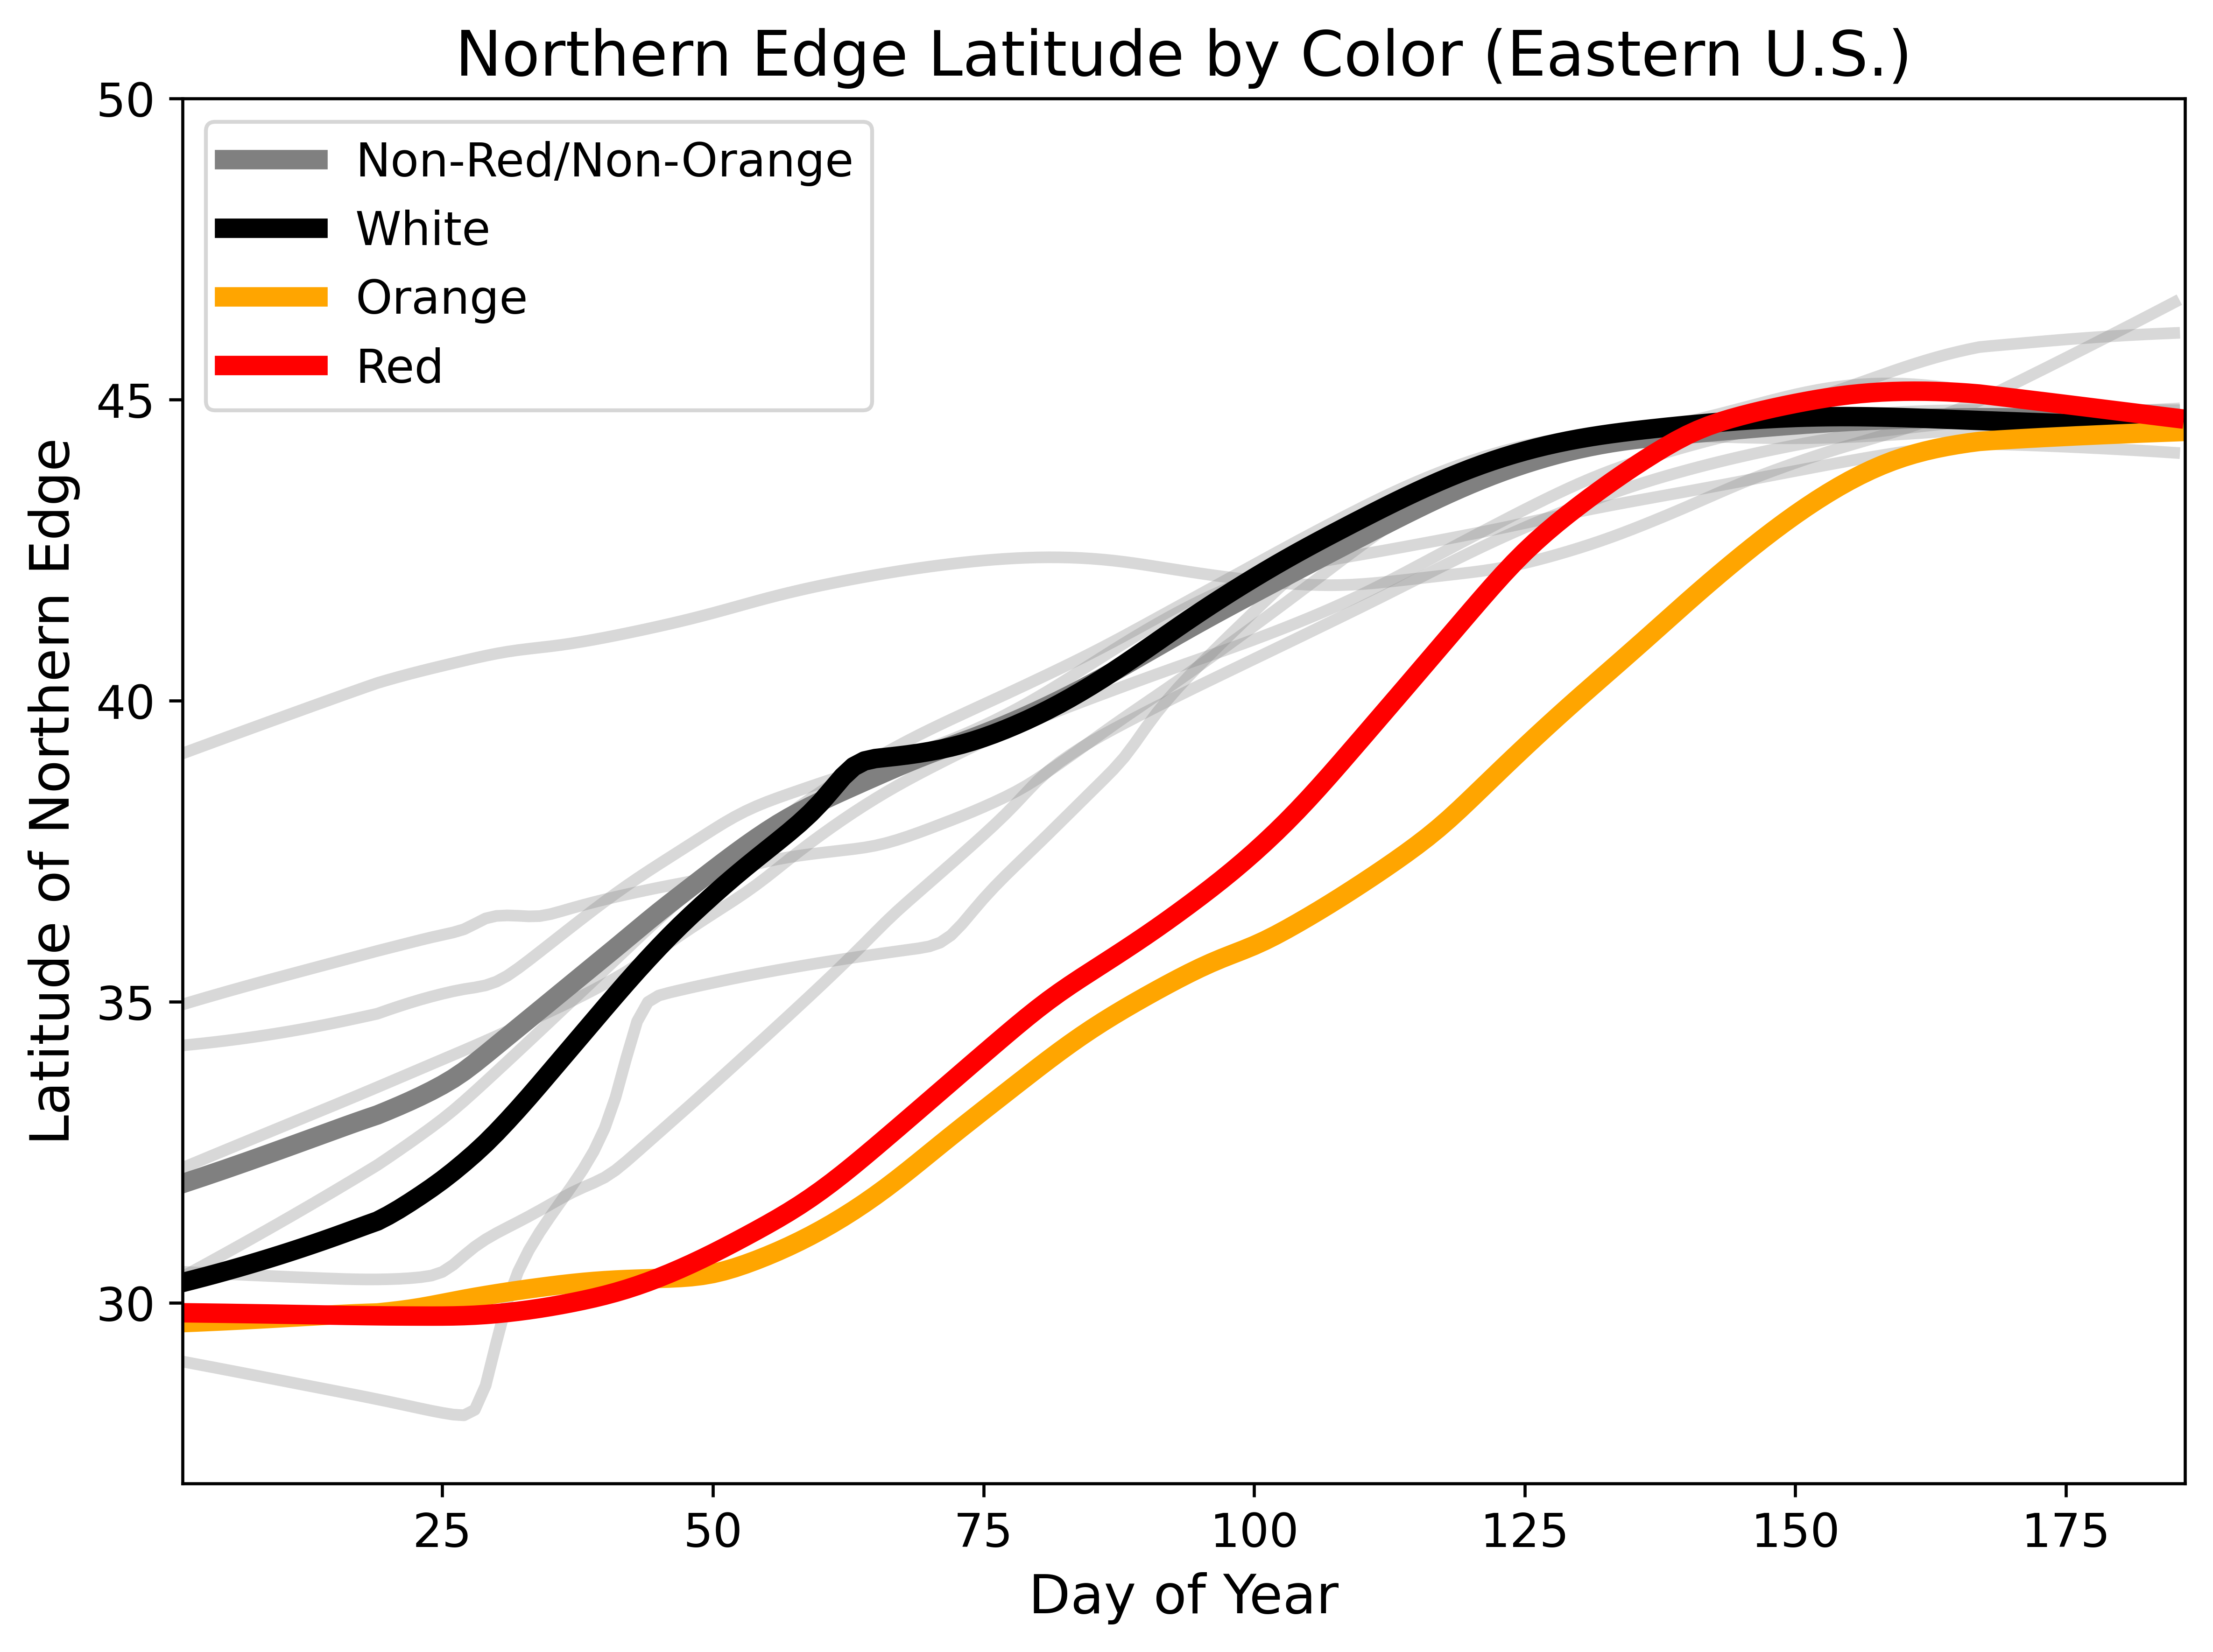

In [6]:
percentile_threshold = 0.8
window_size = 15
max_day = 200 

def calculate_percentiles(dat, color_filter, lon_range, window_size, percentile_threshold, max_day):
    subdf = dat[color_filter]
    subdf = subdf[subdf['lon_window'] == lon_range]
    percentiles = []
    
    for day in range(1, max_day - window_size + 1): 
        day_range = np.arange(day, day + window_size)
        window_df = subdf[subdf['day_of_year'].isin(day_range)]
        if len(window_df) > 0:
            percentile_75 = np.percentile(window_df['latitude'], percentile_threshold * 100)
            percentiles.append(percentile_75)
        else:
            percentiles.append(np.nan)
    return percentiles

# separate filters for the different categories
red_filter = dat['color'] == 'red'
orange_filter = dat['color'] == 'orange'
white_filter = dat['color'] == 'white'
non_red_orange_filter = (~dat['color'].isin(['red', 'orange']))  # non-red, non-orange, and non-white

# colors to lump together (excluding red, orange, and white)
lumped_colors = ['blue', 'maroon', 'yellow', 'brown', 'purple', 'pink', 'green']

# calc percentiles for each of the three lines
percentiles_red = calculate_percentiles(dat, red_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_orange = calculate_percentiles(dat, orange_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_white = calculate_percentiles(dat, white_filter, "-96 to -59", window_size, percentile_threshold, max_day)
percentiles_non_red_orange = calculate_percentiles(dat, non_red_orange_filter, "-96 to -59", window_size, percentile_threshold, max_day)

### Plotting the results###
# high res
plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(8, 6))
x = np.arange(1, max_day - window_size + 1)

# plot all other non-red, non-orange colors as one thick gray line
lowess_non_red_orange = lowess(np.array(percentiles_non_red_orange), x, frac=0.2)
plt.plot(lowess_non_red_orange[:, 0], lowess_non_red_orange[:, 1], label='Non-Red/Non-Orange', color='grey', linewidth=5)

# plot individual lines for all lumped colors as gray/thin
for color in lumped_colors:
    color_filter = dat['color'] == color
    percentiles_individual = calculate_percentiles(dat, color_filter, "-96 to -59", window_size, percentile_threshold, max_day)
    lowess_individual = lowess(np.array(percentiles_individual), x, frac=0.2)
    plt.plot(lowess_individual[:, 0], lowess_individual[:, 1], color='grey', linewidth=3, alpha=0.3)

# plot white separately
lowess_white = lowess(np.array(percentiles_white), x, frac=0.2)
plt.plot(lowess_white[:, 0], lowess_white[:, 1], label='White', color='black', linewidth=5)

# plot red and orange as separate lines
lowess_orange = lowess(np.array(percentiles_orange), x, frac=0.2)
plt.plot(lowess_orange[:, 0], lowess_orange[:, 1], label='Orange', color='orange', linewidth=5)

lowess_red = lowess(np.array(percentiles_red), x, frac=0.2)
plt.plot(lowess_red[:, 0], lowess_red[:, 1], label='Red', color='red', linewidth=5)

# labels
plt.title("Northern Edge Latitude by Color (Eastern U.S.)", fontsize=16)
plt.xlabel("Day of Year", fontsize=14) 
plt.ylabel("Latitude of Northern Edge", fontsize=14)

# tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize=12)
plt.ylim([27, 50])
plt.xlim([1, max_day - window_size + 1])

# save 
plt.savefig('../leading_edge_east.pdf', bbox_inches='tight', dpi=600, format='pdf')
plt.tight_layout()
plt.show()